# Hurtos

Se tienen 6422 datos para entrenamiento y 1606 de testeo

In [53]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, BatchNormalization
from sklearn.metrics import mean_absolute_error, mean_squared_error
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import MinMaxScaler

In [ ]:
df = pd.read_csv("HurtoVehBogota.csv")
df["FECHA.HECHO"] = pd.to_datetime(df["FECHA.HECHO"])
df = df.sort_values("FECHA.HECHO")

In [ ]:
df["log_VehHurt"] = np.log(df["VehHurt"])

# Modelo LSTM

In [ ]:
train_size = int(len(df) * 0.8)
train, test = df.iloc[:train_size], df.iloc[train_size:]

scaler = MinMaxScaler()
scaler.fit(train[["log_VehHurt"]])
train = scaler.transform(train[["log_VehHurt"]])
test = scaler.transform(test[["log_VehHurt"]])

timesteps, features = 10, 1

def split_sequence(sequence, n_steps):
	X, y = list(), list()
	for i in range(len(sequence)):
		end_ix = i + n_steps
		if end_ix > len(sequence)-1:
			break
		seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
		X.append(seq_x)
		y.append(seq_y)
	return np.array(X), np.array(y)

X_train, y_train = split_sequence(train, features)
X_test, y_test = split_sequence(test, features)


X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], features))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], features))

model = Sequential([
    LSTM(50, activation="relu", return_sequences=True, input_shape=(timesteps, features)),
    Dense(1)
])
early_stp = EarlyStopping(monitor="loss", patience=10, restore_best_weights=True)
model.compile(optimizer="adam", loss="mse", metrics=['mae'])
model.fit(X_train, y_train, epochs=100, batch_size=16, verbose=1, callbacks=[early_stp])

Epoch 1/100


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


402/402 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 0.2260 - mae: 0.4150
Epoch 2/100
402/402 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0109 - mae: 0.0784
Epoch 3/100
402/402 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0110 - mae: 0.0790
Epoch 4/100
402/402 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0108 - mae: 0.0789
Epoch 5/100
402/402 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.0108 - mae: 0.0785
Epoch 6/100
402/402 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.0112 - mae: 0.0803
Epoch 7/100
402/402 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0111 - mae: 0.0794
Epoch 8/100
402/402 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0106 - mae: 0.0781
Epoch 9/100
402/402 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0109 - mae: 0.0792
Epoch 10/100
402/402 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0109 - mae: 0.0786
Epoch 11/100
402/402 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0109 - mae: 0.0794
Epoch 12/100
402/402 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0113 - mae: 0.0801
Epoch 13/100
402/402 ━━━━

# Modelo ajustado

In [ ]:
y_pred = model.predict(X_test)
y_pred = y_pred.reshape(-1, 1)
y_pred = scaler.inverse_transform(y_pred)
y_test = scaler.inverse_transform(y_test.reshape(-1, 1))

y_pred = np.exp(y_pred)
y_test = np.exp(y_test)

51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


In [ ]:
# Desempeño

In [55]:
mse = mean_squared_error(
                y_true = y_test,
                y_pred = y_pred
            )
mae = mean_absolute_error(
                y_true = y_test,
                y_pred = y_pred
)
print(f"(RMSE): {np.sqrt(mse)}")
print(f"(MAE): {mae}")

(RMSE): 10.041399251009876
(MAE): 8.21806917695613


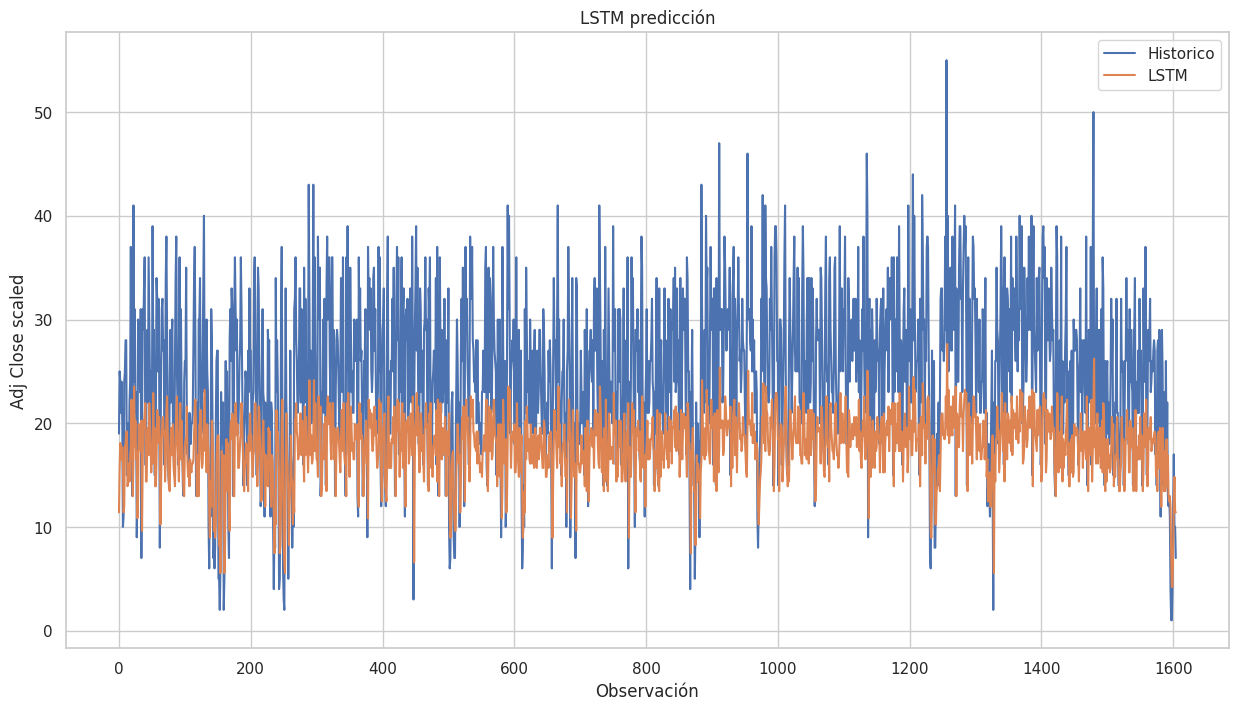

In [ ]:
plt.figure(figsize=(15, 8))
plt.plot(y_test, label='Historico')
plt.plot(y_pred, label='LSTM')
plt.title("LSTM predicción")
plt.xlabel('Observación')
plt.ylabel('Adj Close scaled')
plt.legend()
plt.show();

# Predicciones

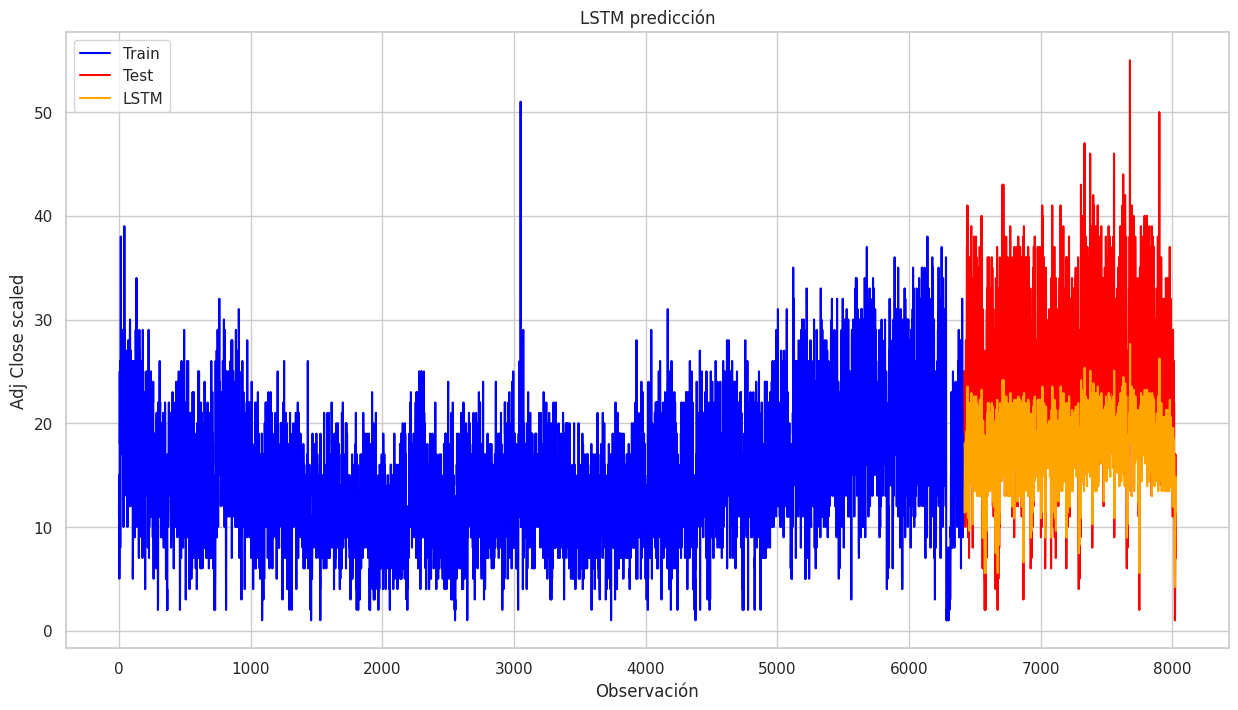

In [44]:
plt.figure(figsize=(15, 8))

plt.plot(np.exp(scaler.inverse_transform(y_train.reshape(-1, 1))), label="Train", color="blue")

plt.plot(range(len(y_train), len(y_train) + len(y_test)), y_test, label="Test", color="red")

plt.plot(range(len(y_train), len(y_train) + len(y_pred)), y_pred, label="LSTM", color="orange")

plt.title("LSTM predicción")
plt.xlabel("Observación")
plt.ylabel("Adj Close scaled")
plt.legend()
plt.show()